<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/water_budget_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Figures from Mason Water Budget

By: Carli Beisel

Created on August, 2024

Purpose: Create figures for each reach.

In [1]:
## --------------- ##
## IMPORT PACKAGES ##
## --------------- ##

import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
# ------------ #
# Custom Colors
# ------------ #

# for Reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Reach 4": "#9E2B25",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Reach": "black"
}

# for WB components
wb_palette = {
    'Qin': '#4BA3C3',     # Inflow
    'Precip (AF)': '#21A179',  # Precipitation
    'SR (AF)': '#D58936',      # SR
    'Qout': '#175676',    # Outflow
    'Evap (AF)': '#E46343',     # Evapotranspiration
    'Residual (AF)': 'none'    # Hollow for Residual
}



In [45]:
## ------------------------------ ##
##     IMPORT WATER BUDGET FILE   ##
## ------------------------------ ##

# Without Surface Runoff
#file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_norunoff.csv') # no surface runoff
# Exclude rows where 'Reach' or another relevant column contains "Noble Drain"
#file = file[file['Reach'] != 'Noble Drain']

# With Surface Runoff
file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_af.csv')
file['Month'] = pd.to_datetime(file['Month'], errors='coerce').dt.strftime('%B')
file = file[file['Reach'] != 'Noble Reach']

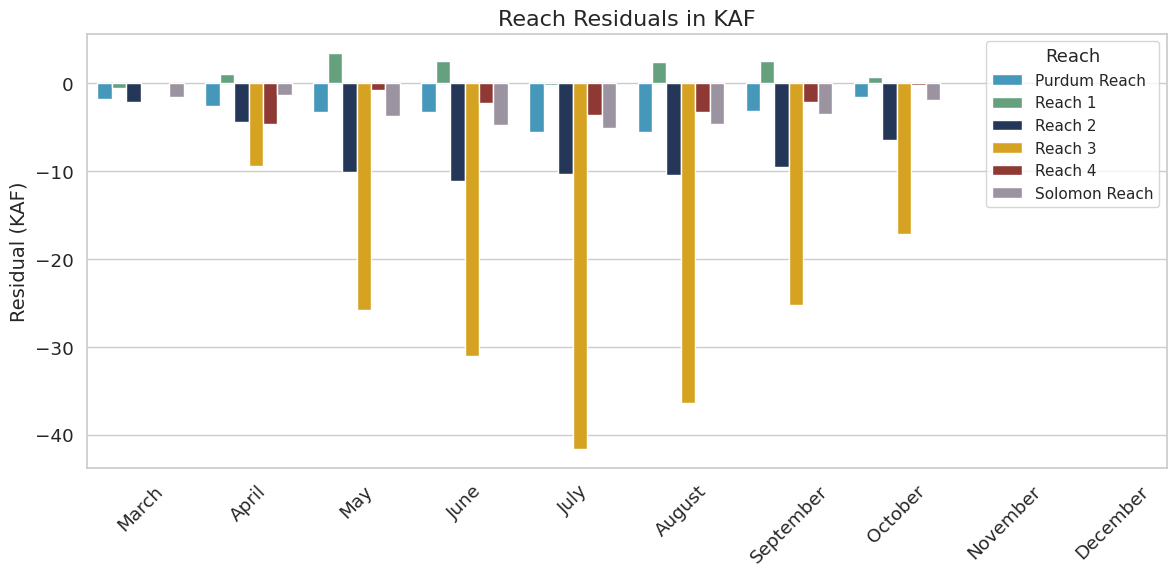

In [35]:
# ---------------- #
# Figure: Residual (KAF)
# ---------------- #

file['Residual (KAF)'] = file['Residual (AF)'] / 1000 #convert to KAF

# Remove rows with NaN values in the new column
file = file.dropna(subset=['Residual (KAF)'])

# Create the bar plot
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=file,
    x='Month', y='Residual (KAF)', hue='Reach',
    palette=reach_palette,
    order=['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

# Update plot labels to reflect KAF
plt.title("Reach Residuals in KAF", fontsize=16)
plt.xlabel("")
plt.ylabel("Residual (KAF)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Reach", title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.show()

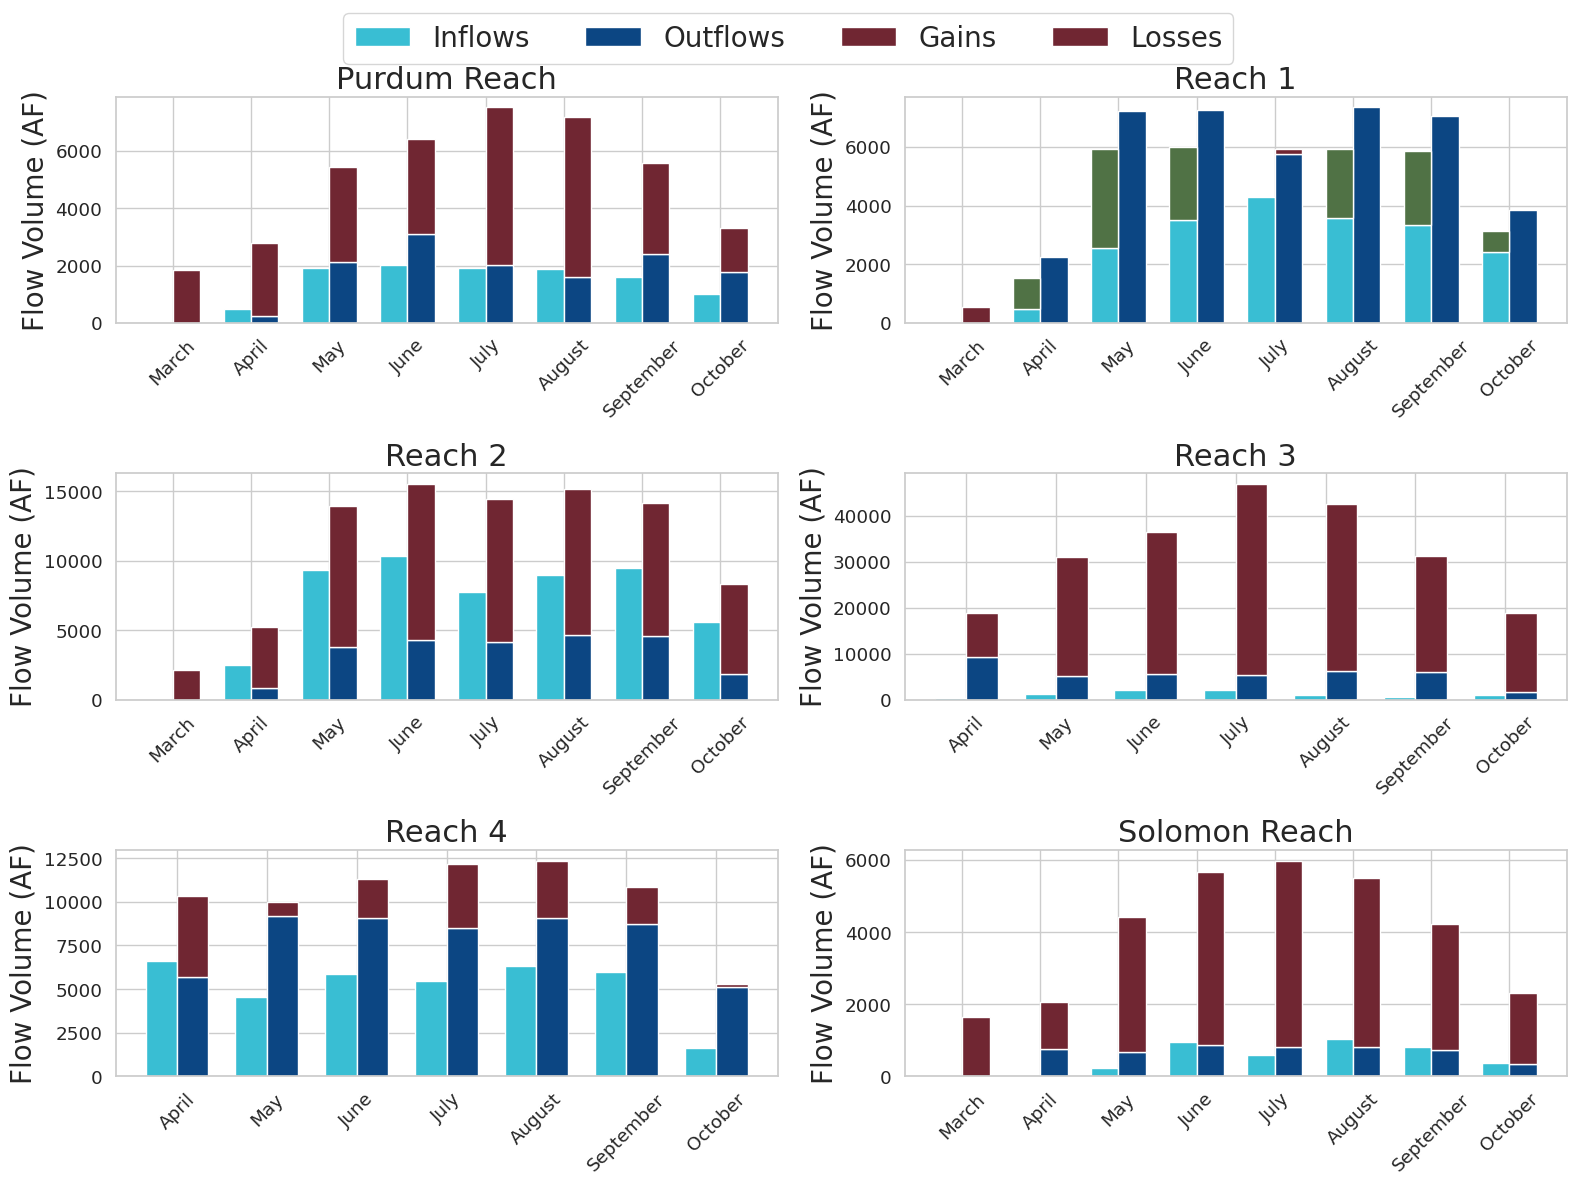

In [36]:
# --------------------- #
# Figure : Inflow/Outflow Comparison
# --------------------- #

# Define custom color palette for inflows, outflows, and residual sides
component_palette = {
    'Inflows': '#39BED3',  # Inflows
    'Outflows': '#0C4683',  # Outflows
    'Residual Inflow': '#507245',  # Residual on inflow side (positive)
    'Residual Outflow': '#702632'  # Residual on outflow side (negative)
}

# Data Preparation: Restructure the DataFrame
file['Inflows'] = file[['Qin', 'Precip (AF)']].sum(axis=1)
file['Outflows'] = file[['Qout', 'Evap (AF)']].sum(axis=1)

# Filter and sort data
months_order = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)

# Get unique reaches
reaches = file['Reach'].unique()

# Set up the grid
rows, cols = 3, 2  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.35  # Width of the bars

    # Plot inflows as positive bars
    ax.bar(
        x - width / 2, reach_data['Inflows'], width, label='Inflows', color=component_palette['Inflows']
    )

    # Plot outflows as positive bars
    ax.bar(
        x + width / 2, reach_data['Outflows'], width, label='Outflows', color=component_palette['Outflows']
    )

    # Plot residuals stacked on inflows or outflows
    for i, residual in enumerate(reach_data['Residual (AF)']):
        if residual > 0:  # Positive residual -> inflow
            ax.bar(
                x[i] - width / 2, residual, width,
                bottom=reach_data['Inflows'].iloc[i],
                color=component_palette['Residual Inflow'], label='Residual (Inflow)' if i == 0 else None
            )
        elif residual < 0:  # Negative residual -> outflow
            ax.bar(
                x[i] + width / 2, abs(residual), width,
                bottom=reach_data['Outflows'].iloc[i],
                color=component_palette['Residual Outflow'], label='Residual (Outflow)' if i == 0 else None
            )

    # Formatting for each subplot
    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45)
    ax.set_title(f"{reach}", fontsize=22)
    ax.set_ylabel("Flow Volume (AF)", fontsize=20)

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Global legend and layout adjustment
fig.legend(['Inflows', 'Outflows', 'Gains', 'Losses'],
           loc='upper center', ncol=4, fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the legend
plt.show()

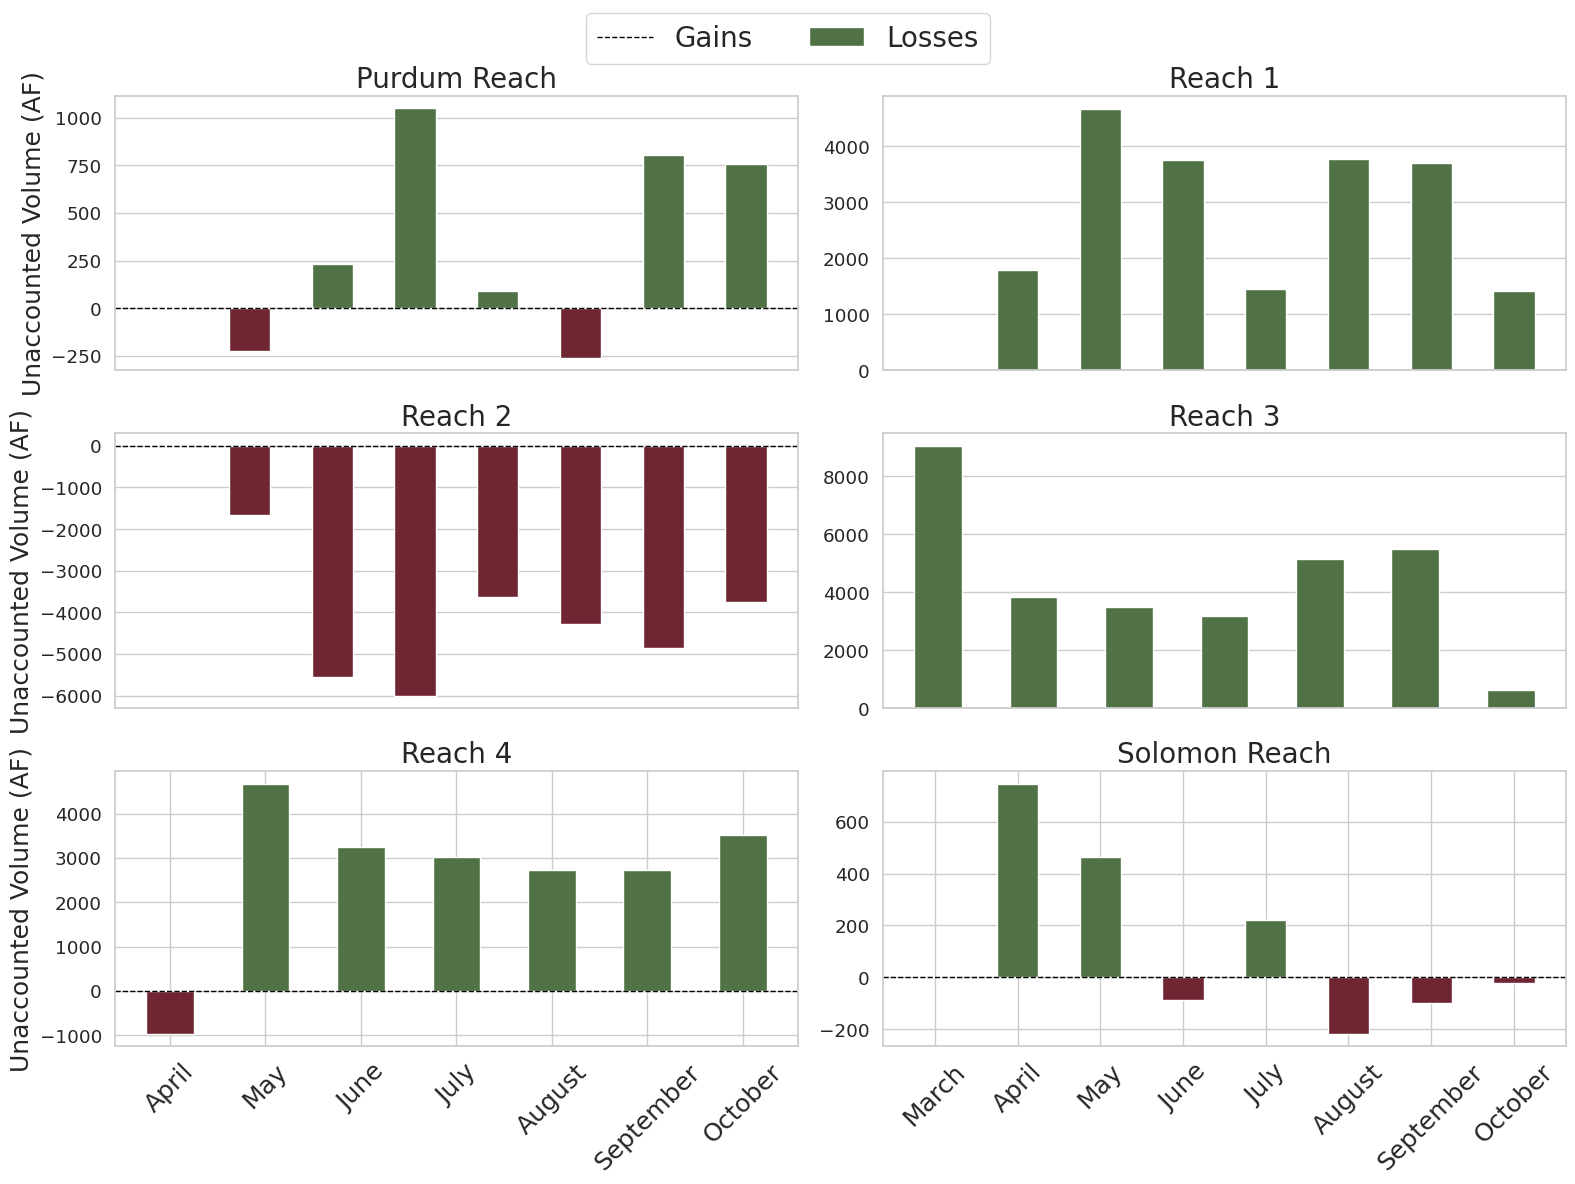

In [33]:
# --------------------- #
# Figure : Unacounted Gains/Losses
# --------------------- #

# Define custom color palette for residuals
residual_palette = {
    'Gains': '#507245',  # Residual on inflow side (positive)
    'Losses': '#702632'   # Residual on outflow side (negative)
}

# Filter and sort data
months_order = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)

# Get unique reaches
reaches = file['Reach'].unique()

# Set up the grid
rows, cols = 3, 2  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Track labels to prevent duplicate entries in the legend
labels_added = {'Positive Residual': False, 'Negative Residual': False}

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.5  # Width of the bars

    # Plot residuals
    for i, residual in enumerate(reach_data['Residual (AF)']):
        if residual > 0:  # Positive residual -> inflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Gains'],
                label='Gains' if not labels_added['Positive Residual'] else None
            )
            labels_added['Positive Residual'] = True
        elif residual < 0:  # Negative residual -> outflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Losses'],
                label='Losses' if not labels_added['Negative Residual'] else None
            )
            labels_added['Negative Residual'] = True

    # Formatting for each subplot
    if idx >= (rows - 1) * cols:  # Only keep tick labels for the bottom row
        ax.set_xticks(x)
        ax.set_xticklabels(reach_data['Month'], rotation=45, fontsize=18)
    else:
        ax.set_xticks([])  # Remove x-axis ticks for other rows
        ax.set_xticklabels([])  # Remove x-axis tick labels

    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # Add a horizontal line at 0
    ax.set_title(f"{reach}", fontsize=20)

    # Only add y-axis labels for leftmost plots
    if idx % cols == 0:
        ax.set_ylabel("Unaccounted Volume (AF)", fontsize=18)
    else:
        ax.set_ylabel("")  # Clear labels for other plots

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Global legend and layout adjustment
fig.legend(['Gains', 'Losses'],
           loc='upper center', ncol=2, fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the legend
plt.show()

In [41]:
file

,Unnamed: 0,Reach,Month,Qin,Qout,Reach Evap (AF),Total Monthly Precip (AF),SR (AF),Qin (AF),Qout (AF),Precip (AF),Evap (AF),Residual (AF)
0,0,Noble Reach,NaN,NaN,NaN,NaN,NaN,4361.771037,NaN,NaN,NaN,NaN,NaN
1,1,Noble Reach,NaN,NaN,NaN,NaN,NaN,4479.841415,NaN,NaN,NaN,NaN,NaN
2,2,Noble Reach,March,NaN,NaN,NaN,NaN,4232.195341,NaN,NaN,NaN,NaN,NaN
3,3,Noble Reach,April,359.901428,337.424884,NaN,NaN,6528.642217,359.901428,337.424884,NaN,NaN,NaN
4,4,Noble Reach,May,426.988902,849.099284,NaN,NaN,11837.835366,426.988902,849.099284,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,Solomon Reach,August,1034.282584,816.287903,0.920993,0.001654,4456.033508,1034.282584,816.287903,0.001654,0.920993,-4673.108850
80,80,Solomon Reach,September,820.185042,722.248958,0.664094,0.072499,3405.581129,820.185042,722.248958,0.072499,0.664094,-3502.925619
81,81,Solomon Reach,October,361.833788,337.654970,0.458239,0.056632,1944.481496,361.833788,337.654970,0.056632,0.458239,-1968.258707
82,82,Solomon Reach,November,NaN,NaN,0.181315,NaN,1505.154498,NaN,NaN,NaN,0.181315,NaN


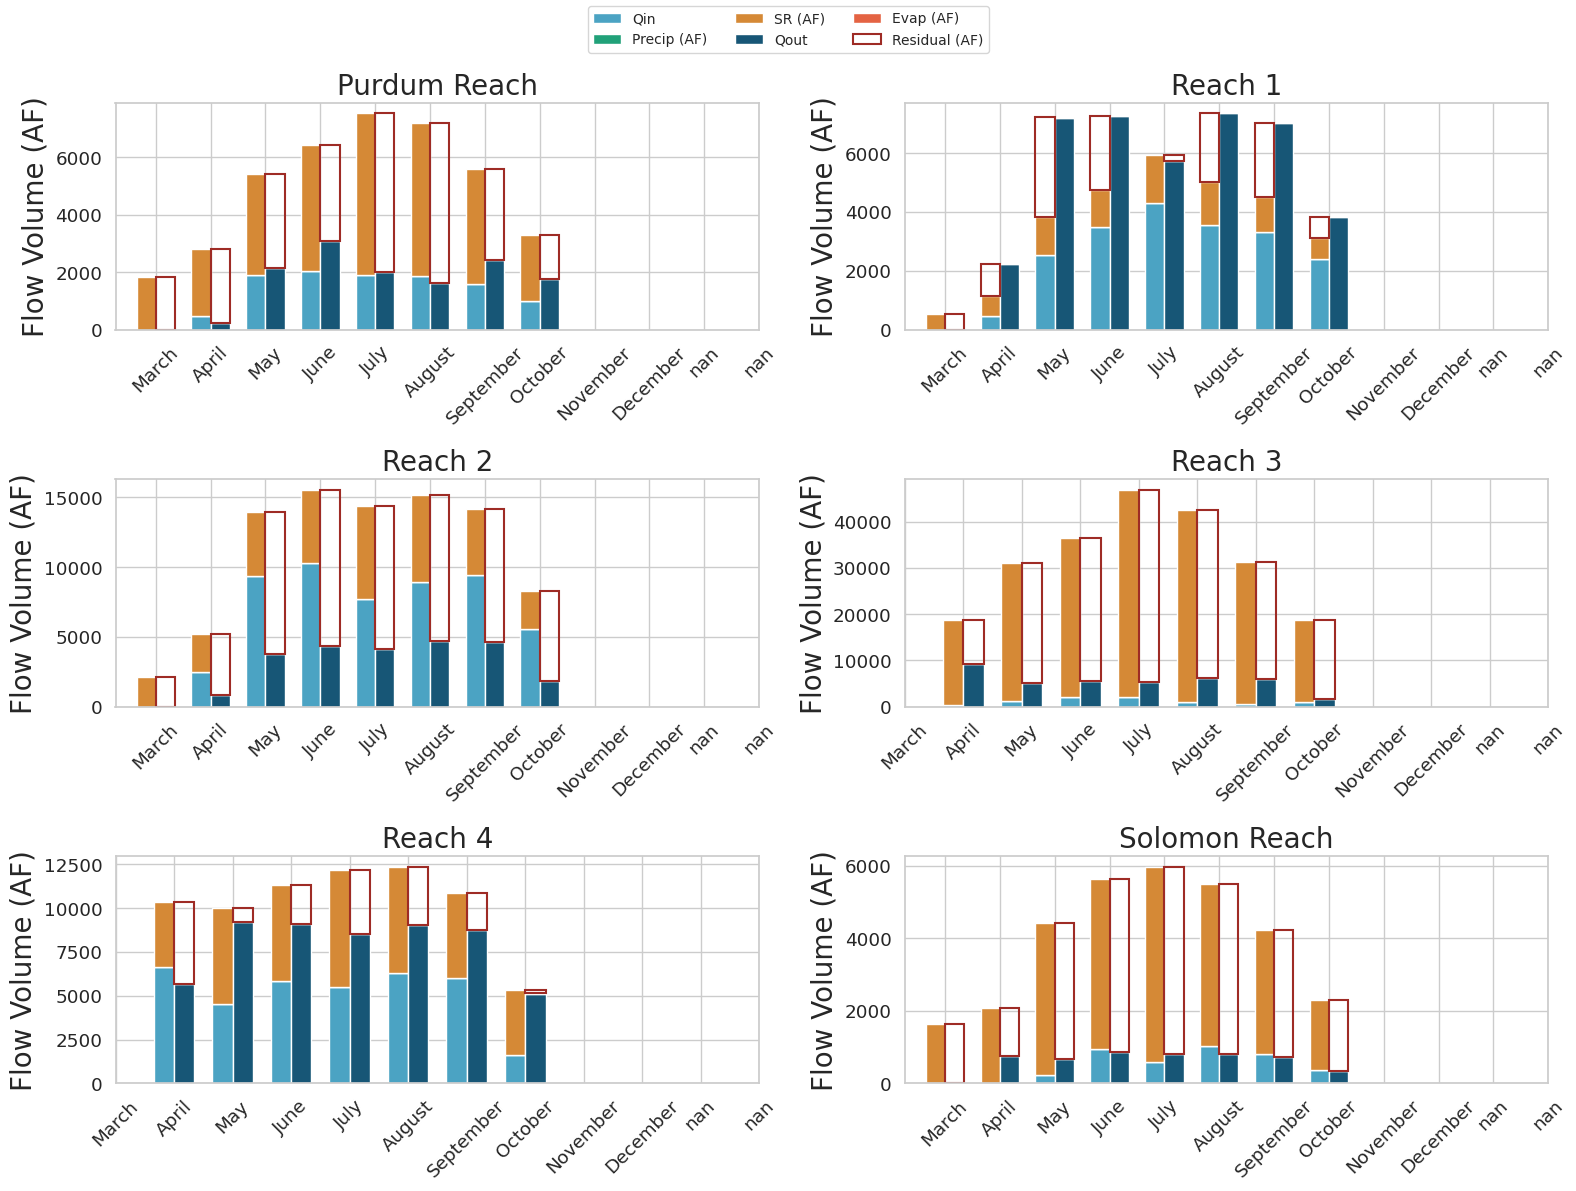

In [46]:
# --------------------- #
# Figure : Water Budget
# --------------------- #

# Edge color for the Residual bar
residual_edge_color = '#9E2B25'

# Separate inflows and outflows
inflows = ['Qin', 'Precip (AF)', 'SR (AF)']
outflows = ['Qout', 'Evap (AF)']

# Sort months in the desired order
months_order = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)

# Get unique reaches
reaches = file['Reach'].unique()

# Define the grid dimensions for the panel layout
rows, cols = 3, 2  # 3 rows, 2 columns
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):  # Skip if more reaches than grid slots
        break

    ax = axes[idx]

    # Filter data for the current reach
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.35  # Width of the bars

    # Initialize bottoms for stacked bars
    inflow_bottom = np.zeros(len(reach_data))
    outflow_bottom = np.zeros(len(reach_data))

    # Plot inflow components (stacked)
    for component in inflows:
        ax.bar(
            x - width / 2, reach_data[component], width,
            label=component, bottom=inflow_bottom, color=wb_palette[component]
        )
        inflow_bottom += reach_data[component].values  # Update bottom for stacking

    # Plot outflow components (stacked)
    for component in outflows:
        ax.bar(
            x + width / 2, reach_data[component], width,
            label=component, bottom=outflow_bottom, color=wb_palette[component]
        )
        outflow_bottom += reach_data[component].values  # Update bottom for stacking

    # Plot Residual (hollow bar with absolute value)
    for i, residual in enumerate(reach_data['Residual (AF)']):
        if residual >= 0:
            ax.bar(
                x[i] - width / 2, abs(residual), width,
                bottom=inflow_bottom[i], color='none',
                edgecolor=residual_edge_color, linewidth=1.5, label='Residual (AF)' if i == 0 else None
            )
        else:
            ax.bar(
                x[i] + width / 2, abs(residual), width,
                bottom=outflow_bottom[i], color='none',
                edgecolor=residual_edge_color, linewidth=1.5, label='Residual (AF)' if i == 0 else None
            )

    # Formatting for each subplot
    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45)
    ax.set_title(f"{reach}", fontsize=20)
    ax.set_ylabel("Flow Volume (AF)", fontsize=20)

# Remove any unused subplots
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Global legend and layout adjustment
fig.legend(wb_palette.keys(), loc='upper center', ncol=3, fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the legend
plt.show()

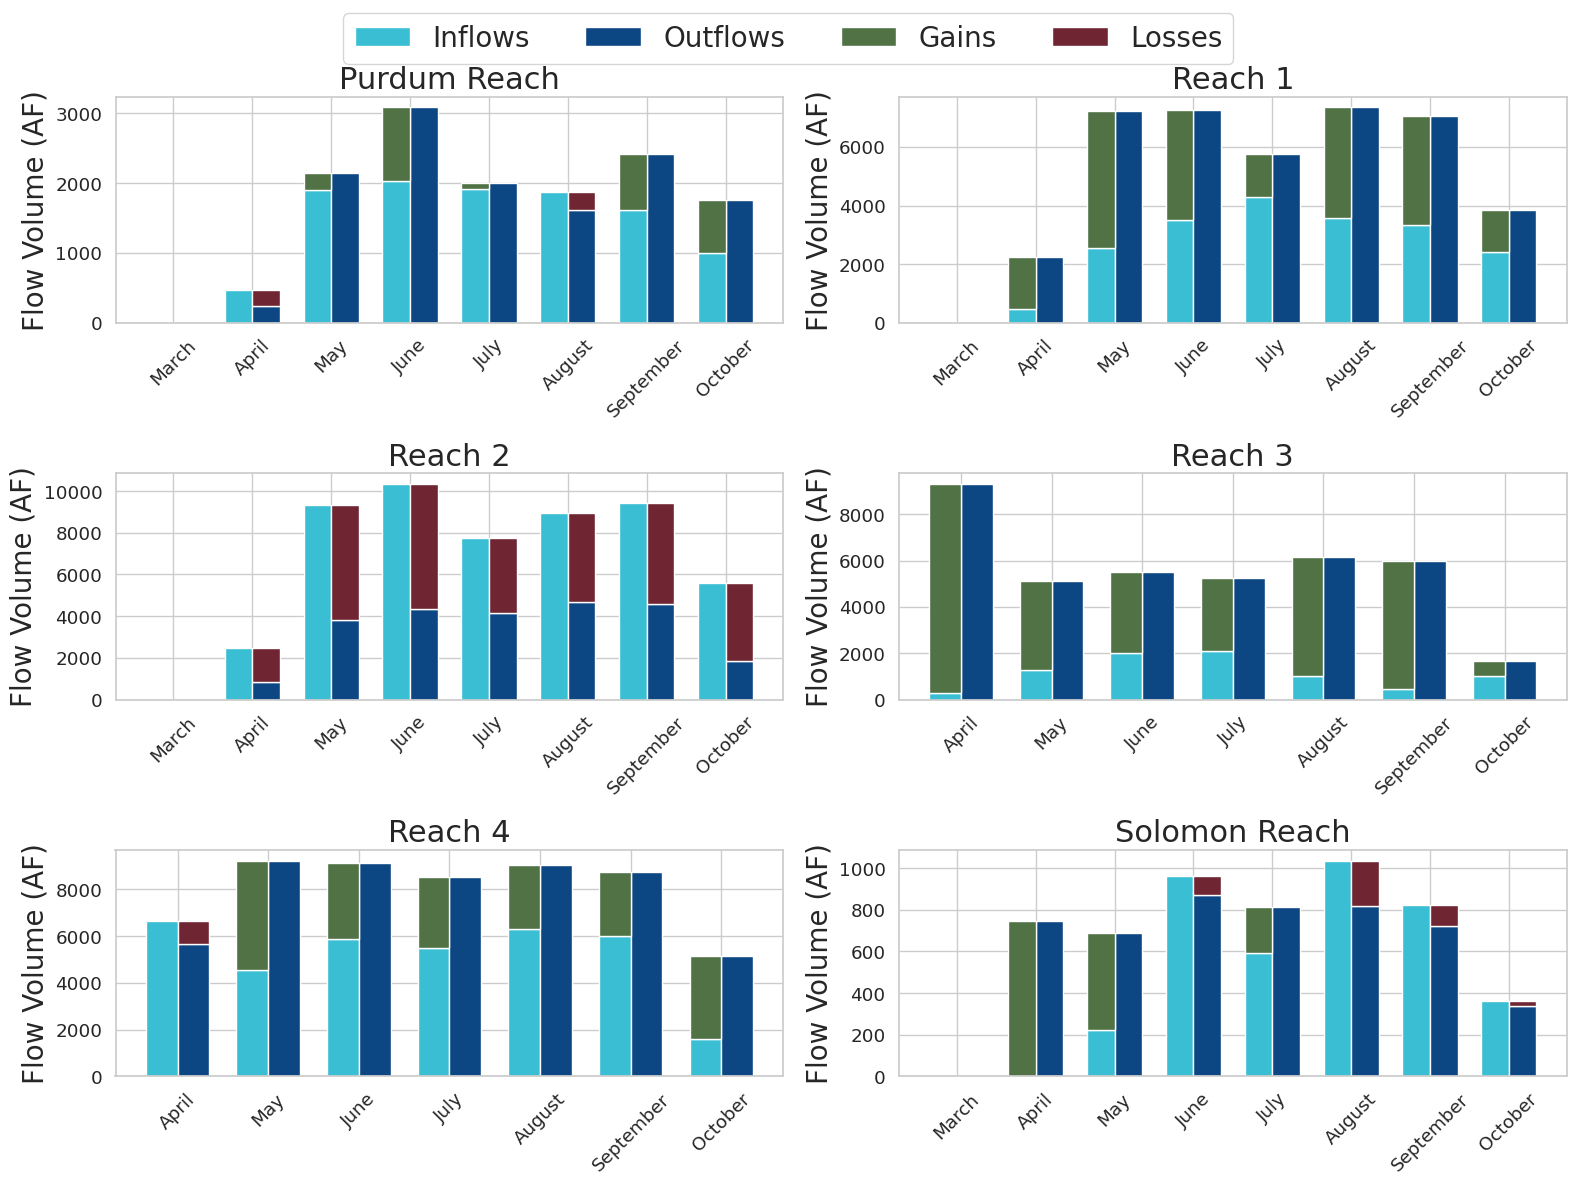

In [17]:
# Define custom color palette for inflows, outflows, and residual sides
component_palette = {
    'Inflows': '#39BED3',  # Inflows
    'Outflows': '#0C4683',  # Outflows
    'Residual Inflow': '#507245',  # Residual on inflow side (positive)
    'Residual Outflow': '#702632'  # Residual on outflow side (negative)
}

# Data Preparation: Restructure the DataFrame
file['Inflows'] = file[['Qin', 'Precip (AF)']].sum(axis=1)
file['Outflows'] = file[['Qout', 'Evap (AF)']].sum(axis=1)

# Filter and sort data
months_order = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)

# Get unique reaches
reaches = file['Reach'].unique()

# Set up the grid
rows, cols = 3, 2  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.35  # Width of the bars

    # Plot inflows as positive bars
    ax.bar(
        x - width / 2, reach_data['Inflows'], width, label='Inflows', color=component_palette['Inflows']
    )

    # Plot outflows as positive bars
    ax.bar(
        x + width / 2, reach_data['Outflows'], width, label='Outflows', color=component_palette['Outflows']
    )

    # Plot residuals stacked on inflows or outflows
    for i, residual in enumerate(reach_data['Residual (AF)']):
        if residual > 0:  # Positive residual -> inflow
            ax.bar(
                x[i] - width / 2, residual, width,
                bottom=reach_data['Inflows'].iloc[i],
                color=component_palette['Residual Inflow'], label='Residual (Inflow)' if i == 0 else None
            )
        elif residual < 0:  # Negative residual -> outflow
            ax.bar(
                x[i] + width / 2, abs(residual), width,
                bottom=reach_data['Outflows'].iloc[i],
                color=component_palette['Residual Outflow'], label='Residual (Outflow)' if i == 0 else None
            )

    # Formatting for each subplot
    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45)
    ax.set_title(f"{reach}", fontsize=22)
    ax.set_ylabel("Flow Volume (AF)", fontsize=20)

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Global legend and layout adjustment
fig.legend(['Inflows', 'Outflows', 'Gains', 'Losses'],
           loc='upper center', ncol=4, fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the legend
plt.show()